In [1]:
import sys
sys.path.insert(1, '../Src')
import numpy as np

import pandas as pd

import os
from utils.feature_engineering import *
from utils.preprocessing import *
import gc
import tqdm
from utils.analysis import *
import matplotlib.pyplot as plt

PATH_DATASET = '../Dataset/'
#PATH_DATASET = '../Dataset/datah-m1-challange/'
PATH_RESULTS = '../Results/'

# loading dataset

In [2]:
df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))
df_items  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','item.pkl'))
df_stores = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','store.pkl'))

df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','submission_sample.pkl'))

df_sales['DATE']= pd.to_datetime(df_sales['DATE'])

df_submission_sample['DATE']= pd.to_datetime(df_submission_sample['DATE'])

N_submission = df_submission_sample.shape[0]
N_sales      = df_sales.shape[0]


In [3]:
df_submission_sample['DATE'].min(),df_submission_sample['DATE'].max()

(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [6]:
sample_sales_unique_filename = os.path.join(PATH_RESULTS,'dataset','sample_sales_unique.pkl')

if os.path.exists(sample_sales_unique_filename):
    print('already exist !')
    sample_sales_unique = pd.read_pickle(sample_sales_unique_filename)
else:
    print('processing ..')
    sample_sales_unique  = get_sample_sales_unique(df_sales,df_submission_sample)
    print('saving ..')
    sample_sales_unique.to_pickle(os.path.join(PATH_RESULTS,'dataset','sample_sales_unique.pkl'))
    print('completed')

processing ..


100%|██████████| 31/31 [00:06<00:00,  4.82it/s]


saving ..
completed


In [7]:
sample_sales_unique.head(2)

,S100,I100,C100,C101,DATE
0,0,0,12,76,2017-01-08
1,0,0,12,76,2017-01-15


In [12]:
df_sales = sample_sales_unique.merge(df_sales,on=['DATE','S100','I100','C100','C101'],how='left')
df_sales.replace([np.inf, -np.inf,np.nan],0 , inplace=True)
print(df_sales.shape)
df_sales.head(2)

(17920125, 7)


,S100,I100,C100,C101,DATE,QTT,item_id
0,0,0,12,76,2017-01-08,2.0,0_12_76
1,0,0,12,76,2017-01-15,1.0,0_12_76


In [13]:
df_sales['DATE'].min(),df_sales['DATE'].max()

(Timestamp('2017-01-08 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [14]:
df_sales[df_sales['DATE']>'2021-08-01'].head(2)

,S100,I100,C100,C101,DATE,QTT,item_id
239,0,0,12,76,2021-08-08,0.0,0
240,0,0,12,76,2021-08-15,0.0,0


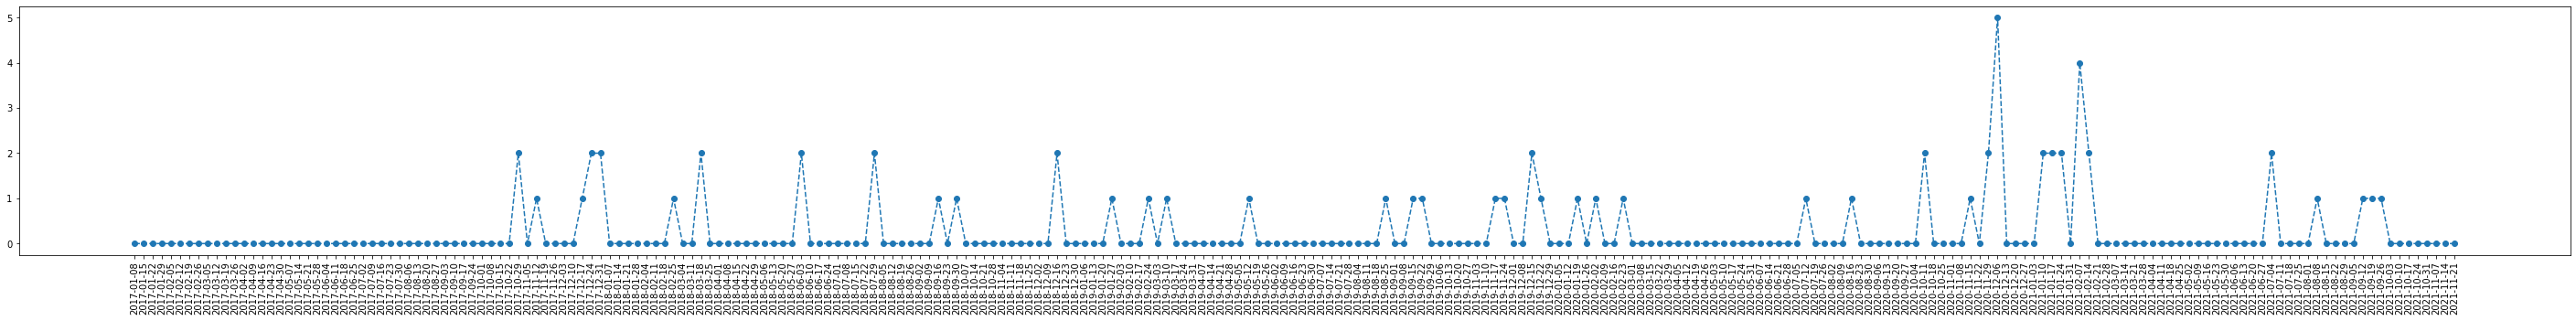

In [15]:
sub_group = get_store_item(df_sales,0,1,12,140)
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--o')
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

In [16]:
df_sales = reduce_mem_usage(df_sales)

Memory usage of dataframe is 1093.76 MB
Memory usage after optimization is: 427.40 MB
Decreased by 60.9%


In [ ]:

df_sales = df_sales.merge(df_items,on=['I100'])
df_sales = df_sales.merge(df_stores,on=['S100'])
    
df_submission_sample = df_submission_sample.merge(df_items,on=['I100'])
df_submission_sample = df_submission_sample.merge(df_stores,on=['S100'])

df_sales.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)

features_names = set(df_sales.columns)-set(['QTT','DATE','item_id','ID'])
print(features_names)

# Feature engineering

In [ ]:
df_sales             = fe_dates(df_sales)
df_submission_sample = fe_dates(df_submission_sample)

In [ ]:
df_sales             = string_to_categorical(df_sales).copy()
df_submission_sample = string_to_categorical(df_submission_sample).copy()

In [ ]:
print(df_sales.shape,df_submission_sample.shape)
df_auxiliar = pd.concat([df_sales,df_submission_sample])
df_auxiliar.replace([np.inf, -np.inf, np.nan],0,inplace=True)

df_auxiliar['item_cnt_unclipped'] = df_auxiliar['QTT']
df_auxiliar['QTT'] = df_auxiliar['QTT'].clip(0, 15)

df_auxiliar = string_to_categorical(df_auxiliar).copy()


In [ ]:
df_auxiliar['date_block_num'] = df_auxiliar['year']*12 + df_auxiliar['month'] - 1

#individual items across all shops
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','I100'],'item_cnt_all_shops',{'QTT':'mean'})
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','C100','S100'],'item_cnt_all_shops_median',{'QTT':'median'}) 
#all items in category at individual shops
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','C100','S100'],'category_cnt',{'QTT':'mean'})
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','C100','S100'],'category_cnt_median',{'QTT':'median'}) 
#all items in category across all shops
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','C100'],'category_cnt_all_shops',{'QTT':'mean'})
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','C100'],'category_cnt_all_shops_median',{'QTT':'median'})


In [ ]:
#all items in group
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','C101','S100'],'group_cnt',{'QTT':'mean'})
#all items in group across all shops
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','C101'],'group_cnt_all_shops',{'QTT':'mean'})
#all items at individual shops
df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','S100'],'shop_cnt',{'QTT':'mean'})
#all items at all shops within the city
#df_auxiliar = agg_cnt_col(df_auxiliar, ['date_block_num','shop_city'],'city_cnt',{'item_cnt':'mean'})

In [ ]:
df_auxiliar['item_age'] = (df_auxiliar['date_block_num'] - df_auxiliar.groupby('I100')['date_block_num'].transform('min')).astype('int8')

df_auxiliar['category_age'] = (df_auxiliar['date_block_num'] - df_auxiliar.groupby('C100')['date_block_num'].transform('min')).astype('int8')
df_auxiliar['group_age'] = (df_auxiliar['date_block_num'] - df_auxiliar.groupby('C101')['date_block_num'].transform('min')).astype('int8')
df_auxiliar['shop_age'] = (df_auxiliar['date_block_num'] - df_auxiliar.groupby('S100')['date_block_num'].transform('min')).astype('int8')

In [ ]:
#mean units sold of new item in category at individual shop
df_auxiliar = new_item_sales(df_auxiliar, ['date_block_num','C100','S100'], 'new_items_in_cat')
#mean units sold of new item in category across all shops
df_auxiliar = new_item_sales(df_auxiliar, ['date_block_num','C100'], 'new_items_in_cat_all_shops')


In [ ]:
lag12_cols = {
    'QTT':['date_block_num', 'S100', 'I100'],
    #'QTT':['date_block_num', 'S100', 'I100','C100','C101'],
    'item_cnt_all_shops':['date_block_num', 'I100'],
    'category_cnt':['date_block_num', 'S100', 'C100'],
    'category_cnt_all_shops':['date_block_num', 'C100'],
    'group_cnt':['date_block_num', 'S100', 'C101'],
    'group_cnt_all_shops':['date_block_num', 'C101'],
    'shop_cnt':['date_block_num', 'S100'],
    #'city_cnt':['date_block_num', 'shop_city'],
    'new_items_in_cat':['date_block_num', 'S100', 'C100'],
    'new_items_in_cat_all_shops':['date_block_num', 'C100']
}
for col,merge_cols in tqdm.tqdm(lag12_cols.items()):
    df_auxiliar[f'{col}_lag1to12'] = 0
    for i in range(1,13):
        df_auxiliar = lag_feature(df_auxiliar, i, col, merge_cols)
        df_auxiliar[f'{col}_lag1to12'] += df_auxiliar[f'{col}_lag{i}']
        if i > 2:
            del df_auxiliar[f'{col}_lag{i}']
    if col == 'QTT':
        del df_auxiliar[f'{col}_lag1']
        del df_auxiliar[f'{col}_lag2']        
    else:
        del df_auxiliar[col]

In [ ]:
lag2_cols = {
    'item_cnt_unclipped':['date_block_num', 'S100', 'I100'],
    'item_cnt_all_shops_median':['date_block_num', 'I100'],
    'category_cnt_median':['date_block_num', 'S100', 'C100'],
    'category_cnt_all_shops_median':['date_block_num', 'C100']
}
for col in tqdm.tqdm(lag2_cols):
    df_auxiliar = lag_feature(df_auxiliar, 1, col, merge_cols)
    df_auxiliar = lag_feature(df_auxiliar, 2, col, merge_cols)
    df_auxiliar = lag_feature(df_auxiliar, 3, col, merge_cols)
    df_auxiliar = lag_feature(df_auxiliar, 4, col, merge_cols)
    
    if col!='item_cnt_unclipped':
        del df_auxiliar[col]

In [ ]:
df_auxiliar['item_cnt_diff'] = df_auxiliar['item_cnt_unclipped_lag1']/df_auxiliar['QTT_lag1to12']
df_auxiliar['item_cnt_all_shops_diff'] = df_auxiliar['item_cnt_all_shops_lag1']/df_auxiliar['item_cnt_all_shops_lag1to12']
df_auxiliar['category_cnt_diff'] = df_auxiliar['category_cnt_lag1']/df_auxiliar['category_cnt_lag1to12']
df_auxiliar['category_cnt_all_shops_diff'] = df_auxiliar['category_cnt_all_shops_lag1']/df_auxiliar['category_cnt_all_shops_lag1to12']

In [ ]:
#total units of item sold at individual shop
df_auxiliar = past_information(df_auxiliar, ['S100','I100'],'item_cnt_sum_alltime',{'QTT':'sum'})
#total units of item sold at all shops
df_auxiliar = past_information(df_auxiliar, ['I100'],'item_cnt_sum_alltime_allshops',{'QTT':'sum'})

#these columns are no longer needed, and would cause data leakage if retained

In [ ]:
df_auxiliar['QTT']= df_auxiliar['item_cnt_unclipped'].copy()
del df_auxiliar['item_cnt_unclipped']


In [ ]:
for col in df_auxiliar.columns:
    if len(df_auxiliar[col].unique()) == 1:
        print('drop unique column',col)
        df_auxiliar.drop(col,inplace=True,axis=1)

In [ ]:
#df_auxiliar = categorical_to_numeric(df_auxiliar)
df_sales, df_submission_sample = df_auxiliar[:N_sales], df_auxiliar[N_sales:]
print(df_sales.shape,df_submission_sample.shape)

In [ ]:
df_submission_sample['DATE'].min(),df_submission_sample['DATE'].max()

In [ ]:
#df_sales2 = df_sales[df_sales['QTT']<=15].copy()

In [ ]:
#df_submission_sample = df_submission_sample[df_submission_sample['S100']==0]

In [ ]:
features_names = set(df_sales.columns)-set(['QTT','DATE','item_id','ID'])
print(features_names)

In [ ]:
from sklearn.model_selection import train_test_split

if True:
    X_train      = df_sales[(df_sales['DATE'] >= '2017-01-01') & (df_sales['DATE'] < '2020-01-01')].copy()
    X_validation = df_sales[(df_sales['DATE'] >= '2021-06-01') & (df_sales['DATE'] < '2021-08-01')].copy()
    X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] < '2021-10-03')].copy() 
    
    #X_train = X_train[X_train['QTT']<=350].copy()

    y_train = X_train['QTT']
    X_train = X_train[features_names]

    y_validation = X_validation['QTT']
    X_validation = X_validation[features_names]

    y_test = X_test['QTT']
    X_test = X_test[features_names]

else:
    #X_train      = df_sales[((df_sales['DATE'] >= '2019-01-01') & (df_sales['DATE'] < '2020-01-01'))|
    #                        ((df_sales['DATE'] >= '2021-01-01') & (df_sales['DATE'] < '2021-08-01'))].copy()
    X_train      = df_sales[((df_sales['DATE'] >= '2017-01-01') & (df_sales['DATE'] < '2021-08-01'))].copy()
    X_test       = df_sales[(df_sales['DATE'] >= '2021-08-01') & (df_sales['DATE'] < '2021-10-03')].copy() 

    y_train = X_train['QTT']
    X_train = X_train[features_names]

    y_test = X_test['QTT']
    X_test = X_test[features_names]

    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
y_submission = df_submission_sample['QTT']
X_submission = df_submission_sample[features_names]

In [ ]:
y_validation.hist(bins=100)


In [ ]:
y_test.hist(bins=100)


In [ ]:
#X_test[y_test.values>25]['S100'].value_counts()

In [ ]:
import lightgbm as lgb

hyper_params = {
    'device':'gpu',
    'is_unbalance':True,
    'is_enable_sparse':True,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'verbose': 0,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    "max_depth": 8,
    "num_leaves": 30,  
    "max_bin": 128,
    "num_iterations": 8000

}

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_validation, y_validation)

In [ ]:
gbm = lgb.train(hyper_params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)

In [ ]:
X_train_pred      = gbm.predict(X_train)#, num_iteration=gbm.best_iteration_)
X_validation_pred = gbm.predict(X_validation)#, num_iteration=gbm.best_iteration_)
X_test_pred       = gbm.predict(X_test)#, num_iteration=gbm.best_iteration_)

X_submission_pred = gbm.predict(X_submission)#, num_iteration=gbm.best_iteration_)

In [ ]:
from sklearn.metrics import mean_squared_error

X_train_pred = np.maximum(X_train_pred, 0)
X_validation_pred = np.maximum(X_validation_pred, 0)
X_test_pred = np.maximum(X_test_pred, 0)
X_submission_pred = np.maximum(X_submission_pred, 0)

df_train_rmse = mean_squared_error(y_train,X_train_pred, squared=False)
df_val_rmse   = mean_squared_error(y_validation,X_validation_pred, squared=False)
df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

print('Final score mean_squared_error')
print('Score train:',df_train_rmse)
print('Score val  :',df_val_rmse)
print('Score test :',df_test_rmse)

In [ ]:
#X_test_pred[0] = 200

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
plt.plot(X_test_pred,'b', alpha=0.7)
plt.plot(y_test.values,'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")

plt.show()

In [ ]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = X_submission_pred
df_submission_sample.head()

In [ ]:
filename_submission= 'submission_baseline01_'+str(np.round(df_test_rmse,4))+'_local.csv'
save = False
if save:
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)

In [ ]:
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

In [ ]:
df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

In [ ]:
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)